In [52]:
import time
import warnings
import random
from datetime import datetime
from pathlib import Path
from tempfile import TemporaryDirectory

import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bson import ObjectId
from pandas.plotting import register_matplotlib_converters
from skimage.color import gray2rgb
from skimage.transform import resize

import brtdevkit
from brtdevkit.core.db import DBConnector, DatetimeFilter
from brtdevkit.util.s3 import S3
from brtlearn.metrics.colorize import colorize_segmentation

%matplotlib inline

In [74]:
# Get the data from Mongo
db = DBConnector()

img_filters = [{
    'project_name': 'shasta',
#     'artifacts.kind': {'$in': ['nrg', 'rgb', 'false-color-palletized']},
    "crop_name": {"$ne": None},
    'artifacts.kind': {'$in': ['nrg', 'truecolor']},
}, DatetimeFilter(key='collected_on', start=datetime(2020, 3, 7))]

start_time = time.time()
df = db.get_documents_df('image', img_filters, limit=None)
elapsed_time = time.time() - start_time
print(f'Queried {len(df)} items in {elapsed_time:.3f} s')
df.head()

2020-04-22 14:45:51,714 - APIRequestor - ERROR - API Authentication failed. rcode: 401, message: b'{"message":"Invalid OAuth access token"}\n'
2020-04-22 14:45:51,714 - APIRequestor - INFO - API access token expired. Refreshing tokens now.


Queried 1466 items in 0.625 s


,_id,is_deleted,collected_on,gnss,annotations,artifacts,has_human_annotation,uuid,angle_to_row,camera_exposure_algo,...,project_name,raw_bit_depth,row_spacing,soil_color,tillage_practice,type,weed_pressure,weeds,icp_version,notes
_id,,,,,,,,,,,,,,,,,,,,,
5e909cba95600bff3c8fe63f,5e909cba95600bff3c8fe63f,False,2020-04-08 22:05:11.337,"{'type': 'Point', 'coordinates': [-96.32641480...","[{'_id': 5e911b3895600bff3c9002f2, '_cls': 'Pi...","[{'_id': 5e909cba95600bff3c8fe63e, 'kind': 'nr...",True,49a0bafe-c542-4687-bd06-955e6c8aba52,PARALLEL,fixed,...,shasta,20,NOT_APPLICABLE,LIGHT,UNKNOWN,raw,UNKNOWN,[NONE],NaN,NaN
5e909cba95600bff3c8fe635,5e909cba95600bff3c8fe635,False,2020-04-08 22:05:10.314,"{'type': 'Point', 'coordinates': [-96.32642, 3...","[{'_id': 5e911b3895600bff3c9002f1, '_cls': 'Pi...","[{'_id': 5e909cba95600bff3c8fe634, 'kind': 'nr...",True,2013b002-9236-489b-aa99-a255a9a51949,PARALLEL,fixed,...,shasta,20,NOT_APPLICABLE,LIGHT,UNKNOWN,raw,UNKNOWN,[NONE],NaN,NaN
5e909cb995600bff3c8fe62b,5e909cb995600bff3c8fe62b,False,2020-04-08 22:05:09.289,"{'type': 'Point', 'coordinates': [-96.3264213,...","[{'_id': 5e911b3895600bff3c9002ec, '_cls': 'Pi...","[{'_id': 5e909cb995600bff3c8fe62a, 'kind': 'nr...",True,e1c35fe4-29cc-465b-91b9-6dfaa1cf9d1e,PARALLEL,fixed,...,shasta,20,NOT_APPLICABLE,LIGHT,UNKNOWN,raw,UNKNOWN,[NONE],NaN,NaN
5e909cbb95600bff3c8fe68f,5e909cbb95600bff3c8fe68f,False,2020-04-08 22:05:08.265,"{'type': 'Point', 'coordinates': [-96.3264267,...","[{'_id': 5e911b3895600bff3c9002fd, '_cls': 'Pi...","[{'_id': 5e909cbb95600bff3c8fe68e, 'kind': 'nr...",True,8cb3246d-ac53-48cd-ab47-79202ffaf452,PARALLEL,fixed,...,shasta,20,NOT_APPLICABLE,LIGHT,UNKNOWN,raw,UNKNOWN,[NONE],NaN,NaN
5e909cbb95600bff3c8fe685,5e909cbb95600bff3c8fe685,False,2020-04-08 22:05:07.241,"{'type': 'Point', 'coordinates': [-96.3264303,...","[{'_id': 5e911b3895600bff3c9002fc, '_cls': 'Pi...","[{'_id': 5e909cbb95600bff3c8fe684, 'kind': 'nr...",True,0d82b863-b2b2-4ff1-bc8e-e6be83dd5e2c,PARALLEL,fixed,...,shasta,20,NOT_APPLICABLE,LIGHT,UNKNOWN,raw,UNKNOWN,[NONE],NaN,NaN


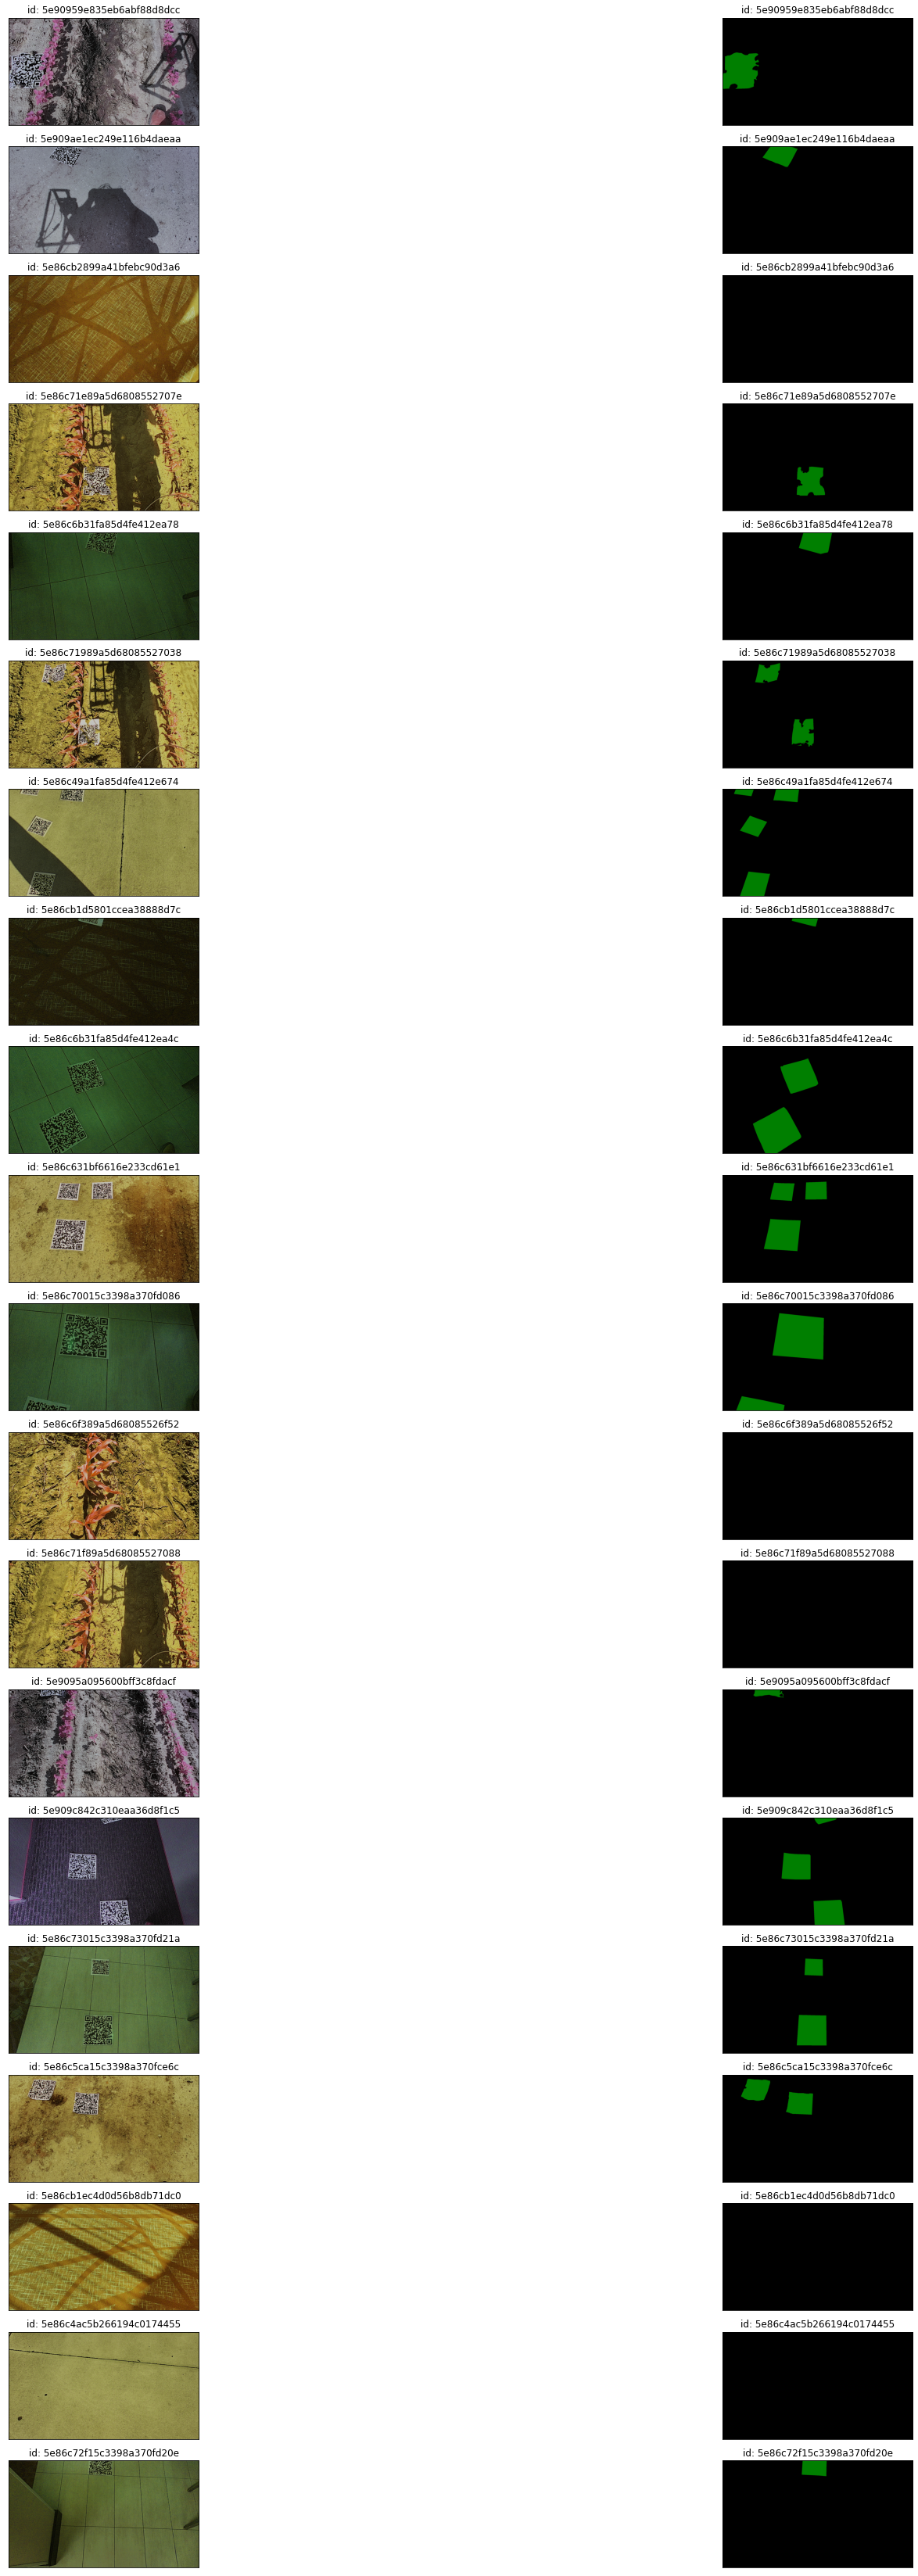

In [76]:
def _download_assets(directory, df):
    """
    Downloads s3 assets of a given list
    Args:
        directory (PathLike | str): the path that the assets will be saved to
        assets (iter(dict)): an iterable containing metadata objects that have s3 assets.
            Will usually be a dataframe column (ex: `image_df['artifacts'].explode()`)
    """
    s3_client = S3()

    def _download(asset, filepath):
        filepath.parent.mkdir(parents=True, exist_ok=True)
        return s3_client.download_file(asset['s3_bucket'], asset['s3_key'], str(filepath))

    for _, row in df.iterrows():
        datapoint_id = str(row['_id'])
        if a['has_human_annotation'].all():
            try:
                annotation = [a for a in row['annotations'] if a['kind'] in ['f8', 'labelbox', 'brt', 'dataloop']][0]
            except:
                annotation = [a for a in row['annotations'] if a['kind'] == 'ndvi_mask'][0]
        else:
            try:
                annotation = [a for a in row['annotations'] if a['kind'] == 'ndvi_mask'][0]
            except:
                annotation = random.choice(row['annotations'])
        try:
            nrg_artifact = [a for a in row['artifacts'] if a['kind'] == 'false-color-palletized'][0]
        except:
            try:
                nrg_artifact = [a for a in row['artifacts'] if a['kind'] == 'nrg'][0]
            except:
                try: 
                    nrg_artifact = [a for a in row['artifacts'] if a['kind'] == 'rgb'][0]
                except:
                    nrg_artifact = random.choice(row['artifacts'])
        _download(nrg_artifact, Path(directory) / f'{datapoint_id}_nrg.png')
        _download(annotation, Path(directory) / f'{datapoint_id}_ann.png')


def sample_and_display_images(df_sample):
    """
    Downloads s3 assets of a given list into a TemporaryDirectory and Displays images
    """

    # Sample dataframe and combine it with annotations and artifacts.
    res = list()
    # Download to a temporary directory and read NRG and NDVI into an array.
    with TemporaryDirectory() as tmp_dir:
        _download_assets(tmp_dir, df_sample)
        for name in df_sample['_id'].to_list():
            nrg = imageio.imread(Path(tmp_dir) / f'{name}_nrg.png')
            ann = colorize_segmentation(np.zeros_like(nrg), imageio.imread(Path(tmp_dir) / f'{name}_ann.png'))
            res.append((name, nrg, ann))

    # Display images
    fig, ax = plt.subplots(len(res), 2, figsize=(30, 60))
    for i, (image_id, nrg, ndvi) in enumerate(res):
        for j, arr in enumerate((nrg, ndvi)):
            ax[i, j].imshow(arr)
            ax[i, j].set_title(f'id: {image_id}')
            ax[i, j].get_yaxis().set_visible(False)
            ax[i, j].get_xaxis().set_visible(False)

df_sample = df.sample(n=20)
sample_and_display_images(df_sample)

In [73]:
df.crop_name.value_counts()

NONE_FALLOW_PRE_EMERGE    1172
CORN                       153
SOYBEANS                   141
Name: crop_name, dtype: int64